In [1]:
# Clear workspace
%reset

# standard packages
from math import e
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
import os
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, precision_recall_curve, plot_precision_recall_curve
from scipy.stats import sem
pd.options.display.max_colwidth = 100

# SGL packages
from group_lasso import LogisticGroupLasso
LogisticGroupLasso.LOG_LOSSES = True

%reload_ext autoreload
%autoreload 2

working_dir = "~/Desktop/hif2gene"


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
seed = 360
np.random.seed(seed)

## Load in HIFs + Clusters 

In [4]:
# Load in HIF dataset with labels
# NAs removed, already converted to patient-level
df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/skcm.TIGIT.joined.USE.csv".format(working_dir))
df = df.iloc[:,1:]
df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE,joined.TIGIT_label
0,58.410292,53.133976,8.487664,20.831352,79.241644,5723.204890,7052.892894,5909.072239,5398.003602,4972.708760,...,71.263034,1.951711,1.505628,10.368986,4.164477,22.855561,29.717332,70.422697,35.360195,0
1,256.376624,183.026400,2.260484,61.300676,317.677300,7591.695389,6799.001714,6174.721407,7723.272265,7040.788998,...,1740.542998,0.717694,4.922787,13.947644,3.270615,172.800466,380.874016,770.007822,288.040726,1
2,37.396100,26.768540,6.131536,15.393604,52.789704,6964.023615,6433.440113,5856.913640,6844.596156,5283.126766,...,847.646352,0.855704,8.405389,20.333120,6.535365,26.901201,221.416633,528.531200,173.177709,1
3,10.165232,6.265320,1.732884,2.928880,13.094112,6886.846265,6088.203122,5685.941178,6567.141658,5691.419741,...,418.814197,1.180494,2.234523,19.119937,5.193174,168.318834,210.843181,347.573134,208.414286,0
4,22.468416,7.640144,0.436284,1.864220,24.332636,7183.081816,5936.683983,6027.202861,7252.723793,4185.228735,...,350.311409,0.801125,5.497279,23.602365,2.548018,46.732266,158.504866,518.179185,82.851689,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,199.295932,105.349612,3.874452,56.462540,255.758472,6308.553319,5470.245899,5027.951948,6339.893851,6752.835381,...,801.302879,0.220777,0.768869,1.434579,0.488742,119.500683,151.590497,164.250492,129.379878,1
229,56.896288,44.219920,3.791788,22.847336,79.743624,6262.027952,6762.026733,5543.724686,6212.307570,5177.221316,...,1362.140251,7.100639,19.312563,55.673887,21.017354,142.592782,561.398573,1163.023995,434.956405,1
230,146.597648,37.981336,10.317812,18.585056,165.182704,7054.863156,5189.711650,5083.940664,7082.000846,3528.111089,...,122.767091,0.238749,2.185284,40.355004,4.752314,8.833702,74.720910,235.027540,34.283250,0
231,366.084516,29.663968,8.606332,9.045324,375.129840,7329.341194,4570.850192,4151.867325,7405.661224,4138.801248,...,282.379562,7.593875,5.022929,58.372702,8.818280,28.796629,75.445065,258.697201,34.340110,1


In [5]:
# Normalize HIFs and define X, y
X = df.iloc[:,:607]
X_normalized = (X-X.mean())/X.std()
X_normalized

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._FFPE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE
0,-0.468336,-0.178110,-0.178303,-0.413624,-0.501480,-1.128928,1.013280,0.250362,-1.866792,-0.262843,...,-0.990922,-0.681380,-0.147471,-0.300768,-0.581192,-0.272863,-0.572367,-0.871148,-0.872089,-0.836519
1,1.933666,2.123366,-0.475261,0.929173,1.840068,0.921252,0.698789,0.550316,1.110397,1.448879,...,1.514257,0.924129,-0.165937,-0.234295,-0.499036,-0.290233,0.239684,0.410146,0.564740,0.300611
2,-0.723309,-0.645261,-0.290661,-0.594052,-0.761250,0.232547,0.245973,0.191468,-0.014628,-0.005914,...,0.529703,0.065343,-0.163872,-0.166548,-0.352444,-0.226790,-0.550458,-0.171679,0.068788,-0.216303
3,-1.053712,-1.008544,-0.500421,-1.007639,-1.151079,0.147865,-0.181667,-0.001583,-0.369871,0.332024,...,-0.633167,-0.347106,-0.159012,-0.286589,-0.380296,-0.252873,0.215413,-0.210259,-0.302869,-0.057729
4,-0.904433,-0.984185,-0.562253,-1.042965,-1.040712,0.472906,-0.369351,0.383747,0.507924,-0.914629,...,0.474894,-0.412992,-0.164689,-0.223119,-0.277392,-0.304275,-0.443059,-0.401230,0.047527,-0.622795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,1.241084,0.747063,-0.398295,0.768640,1.231997,-0.486661,-0.947121,-0.744542,-0.660830,1.210544,...,-0.413468,0.020770,-0.173373,-0.315100,-0.786300,-0.344292,-0.048970,-0.426459,-0.679382,-0.413405
229,-0.486706,-0.336052,-0.402237,-0.346733,-0.496550,-0.537710,0.652988,-0.162165,-0.824187,-0.093571,...,0.806655,0.560182,-0.070422,0.045628,0.458876,0.054633,0.076089,1.068841,1.371928,0.961771
230,0.601675,-0.446590,-0.091028,-0.488158,0.342501,0.332219,-1.294614,-0.681323,0.289336,-1.458517,...,-0.553874,-0.631844,-0.173104,-0.287547,0.107199,-0.261440,-0.648305,-0.706940,-0.534019,-0.841366
231,3.264794,-0.593959,-0.172644,-0.804692,2.404279,0.633387,-2.061188,-1.733759,0.703739,-0.953057,...,-0.061356,-0.478329,-0.063041,-0.232346,0.520833,-0.182427,-0.540193,-0.704297,-0.485405,-0.841110


In [6]:
y = df.iloc[:,607]
print(np.sum(y))

134


In [7]:
# Load in clusters
clusters = pd.read_csv("{0}/data/hif_clusters/SKCM.hif.clusters.csv".format(working_dir))
print("Number of Clusters: {0}".format(len(set(clusters['x']))))
clusters


Number of Clusters: 24


,Unnamed: 0,x
0,AREA (MM2) OF [EPITHELIAL] IN [TISSUE]_HE,1
1,AREA (MM2) OF [ESI_0080] IN [TISSUE]_HE,1
2,AREA (MM2) OF [NECROSIS] IN [TISSUE]_HE,2
3,AREA (MM2) OF [STROMA] IN [TISSUE]_HE,3
4,AREA (MM2) OF [TUMOR] IN [TISSUE]_HE,1
...,...,...
602,TOTAL [MACROPHAGE CELLS] IN [TUMOR]_HE,8
603,TOTAL [PLASMA CELLS] IN [EPITHELIAL]_HE,9
604,TOTAL [PLASMA CELLS] IN [ESI_0080]_HE,9
605,TOTAL [PLASMA CELLS] IN [STROMA]_HE,9


## Define Nested CV Parameters

In [8]:
num_outer_loops = 3 # for estimating generalization error
num_inner_loops = 5 # for hyper-parameter tuning
training_aurocs = [0.0, 0.0, 0.0]
generalization_aurocs = [0.0, 0.0, 0.0]
training_auprcs = [0.0, 0.0, 0.0]
generalization_auprcs = [0.0, 0.0, 0.0]

# Define outer loops (A, B, and C)
X_train_AB, X_train_C, y_train_AB, y_train_C = train_test_split(X_normalized, y, test_size=1/3, random_state=seed, stratify=y)
X_train_A, X_train_B, y_train_A, y_train_B = train_test_split(X_train_AB, y_train_AB, test_size=1/2, random_state=seed, stratify=y_train_AB)

# Verify correctness
print(len(X_train_A), len(y_train_A))
print(len(X_train_B), len(y_train_B))
print(len(X_train_C), len(y_train_C))

print(np.sum(y_train_A)/len(y_train_A))
print(np.sum(y_train_B)/len(y_train_B))
print(np.sum(y_train_C)/len(y_train_C))

77 77
78 78
78 78
0.5714285714285714
0.5769230769230769
0.5769230769230769


### Outer Loop 1

In [9]:
# Define outer loop train and test
X_train_1 = np.array(X_train_A.append(X_train_B))
y_train_1 = np.array(y_train_A.append(y_train_B))
print(X_train_1.shape, y_train_1.shape)

X_test_1 = np.array(X_train_C)
y_test_1 = np.array(y_train_C)
print(X_test_1.shape, y_test_1.shape)

(155, 607) (155,)
(78, 607) (78,)


In [9]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_1, y_train_1)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-7, -2, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_1, y_train_1):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_1[train_index], X_train_1[test_index]
        y_train, y_test = y_train_1[train_index], y_train_1[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.8391079508726568, 0.8416576887165123, 0.8425123895712131, 0.8450621274150686, 0.8476118652589241, 0.8510019392372333, 0.852696976226388, 0.8518422753716871, 0.8569561157796451, 0.8603892839186956, 0.8612296200531494, 0.8671407024348202, 0.8697048049989228, 0.8807297277885514, 0.8892623716153129, 0.8926524455936221, 0.9011707247001365, 0.9028801264095382, 0.9028801264095382, 0.9028083028083028, 0.9053436759319112, 0.9018961430726137, 0.899317675788264, 0.8916253680959564, 0.887337499102205, 0.8787761258349495, 0.8770523594053007, 0.8685771744595275, 0.8643323996265174, 0.5470085470085471]


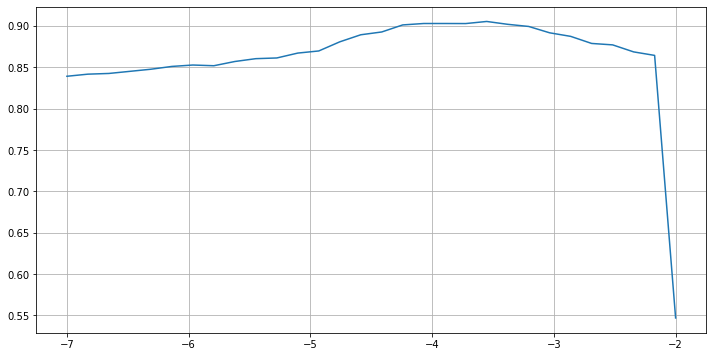

0.02867515708310305 -3.5517241379310343


In [12]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -4.3
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_1, y_train_1)

# Store optimal model
optimal_sgl_1 = optimal_sgl

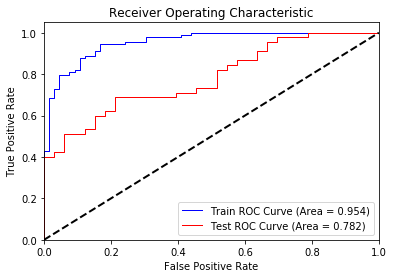

In [11]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_1)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_1)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_1, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[0] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_1, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[0] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

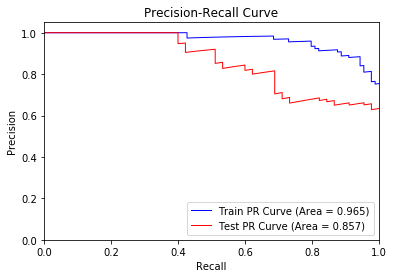

In [12]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_1, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[0] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_1, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[0] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_1 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_1[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_1, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 56


,HIF,Beta,Cluster
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.488490,20
513,REGION PROPERTIES: PERIMETER^2 / AREA OF NECROSIS_HE,0.372650,2
433,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF NECROSIS_HE,0.184849,2
430,REGION PROPERTIES: AVERAGE EXTENT OF SIGNIFICANT REGIONS OF TUMOR_HE,0.155331,19
508,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF EPITHELIAL_HE,0.124123,20
435,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF TUMOR_HE,0.117761,19
331,COUNT PROP [[[CANCER CELLS] SELECTED BY [PLASMA_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY [MA...,0.100541,8
304,COUNT PROP [[[CANCER CELLS] SELECTED BY [MACROPHAGE_RADIUS_80]] OVER [[CANCER CELLS] SELECTED BY...,0.087615,8
342,DENSITY RATIO [CANCER CELLS] IN [[TUMOR] OVER [ESI_0080]]_HE,0.082102,4
115,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN TUMOR_HE,0.074815,3


### Outer Loop 2

In [14]:
# Define outer loop train and test
X_train_2 = np.array(X_train_A.append(X_train_C))
y_train_2 = np.array(y_train_A.append(y_train_C))
print(X_train_2.shape, y_train_2.shape)

X_test_2 = np.array(X_train_B)
y_test_2 = np.array(y_train_B)
print(X_test_2.shape, y_test_2.shape)

(155, 607) (155,)
(78, 607) (78,)


In [29]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_2, y_train_2)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_2, y_train_2):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_2[train_index], X_train_2[test_index]
        y_train, y_test = y_train_2[train_index], y_train_2[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.808525461466638, 0.8102492278962867, 0.8119586296056884, 0.8128133304603893, 0.8128133304603893, 0.8145083674495439, 0.8136680313150901, 0.8110895640307405, 0.808525461466638, 0.8110608345902464, 0.8050922933275875, 0.8025281907634849, 0.803425985778927, 0.8034403504991741, 0.8034116210586799, 0.8033828916181858, 0.8076133017309488, 0.8160022983552395, 0.816088486676722, 0.8185376714788479, 0.8160453925159807, 0.7949220713926597, 0.8109028226675286, 0.814321626086332, 0.8160453925159807, 0.8126696832579186, 0.810105580693816, 0.8101343101343101, 0.8050204697263521, 0.8076133017309488]


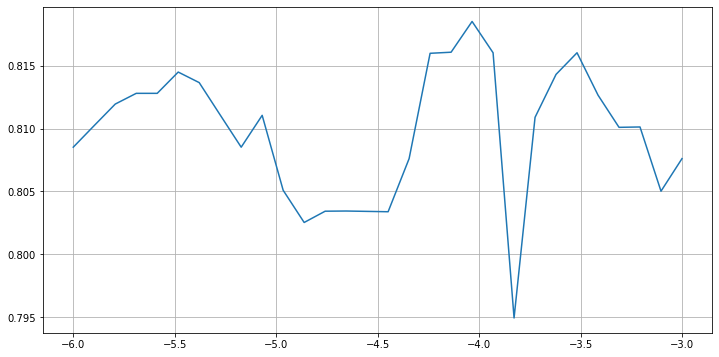

0.01769483024496462 -4.0344827586206895


In [32]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_2, y_train_2)

# Store optimal model
optimal_sgl_2 = optimal_sgl

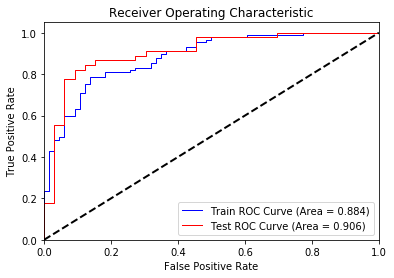

In [16]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_2)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_2)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_2, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[1] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_2, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[1] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

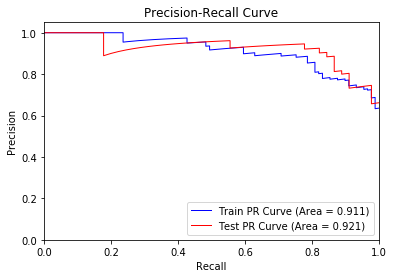

In [17]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_2, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[1] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_2, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[1] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_2 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_2[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_2, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 21


,HIF,Beta,Cluster
513,REGION PROPERTIES: PERIMETER^2 / AREA OF NECROSIS_HE,0.310319,2
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.112195,20
435,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF TUMOR_HE,0.105432,19
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.072838,22
478,REGION PROPERTIES: LACUNARITY OF NECROSIS_HE,0.045499,2
114,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN STROMA_HE,0.030043,3
115,CELL CLUSTERING PROPERTIES: CLUSTER SIZE STANDARD DEVIATION OF FIBROBLAST IN TUMOR_HE,0.028166,3
155,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN TUMOR_HE,0.025243,3
94,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN STROMA_HE,0.024403,3
154,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN STROMA_HE,0.024147,3


### Outer Loop 3

In [19]:
# Define outer loop train and test
X_train_3 = np.array(X_train_B.append(X_train_C))
y_train_3 = np.array(y_train_B.append(y_train_C))
print(X_train_3.shape, y_train_3.shape)

X_test_3 = np.array(X_train_A)
y_test_3 = np.array(y_train_A)
print(X_test_3.shape, y_test_3.shape)

(156, 607) (156,)
(77, 607) (77,)


In [38]:
# Define k-folds object
skf = StratifiedKFold(n_splits=num_inner_loops)
skf.get_n_splits(X_train_3, y_train_3)

5

In [ ]:
# K-folds: hyper-parameter tuning
num_regs = 30
regs = list(np.logspace(-6.0, -3.0, num_regs, base=e))
print(regs)

cv_aucs = [] # based on k-folds CV

for reg in regs:
    print(reg)
    k_folds_count = 1
    
    aucs = [] 
    for train_index, test_index in skf.split(X_train_3, y_train_3):
        print(k_folds_count)

        # Define train / test
        X_train, X_test = X_train_3[train_index], X_train_3[test_index]
        y_train, y_test = y_train_3[train_index], y_train_3[test_index]
        print(np.sum(y_train)/len(y_train), np.sum(y_test)/len(y_test))
        print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
        
        # SGL 
        sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=reg*(1/6), l1_reg=reg*(5/6), n_iter=1000, 
                                 tol=1e-6, old_regularisation=False, warm_start=True, random_state=seed)
        sgl.fit(X_train, y_train)

        # Compute AUC on test set
        y_probs_test = sgl.predict_proba(X_test)[1] # predicted probability y = 1
        fpr, tpr, thresholds = roc_curve(y_test, y_probs_test, pos_label=1)
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)

        k_folds_count += 1
    
    print(aucs)
    cv_aucs.append(np.mean(np.array(aucs)))

[0.771916971916972, 0.771916971916972, 0.7744200244200244, 0.7744200244200244, 0.7778998778998779, 0.7778388278388279, 0.7802808302808303, 0.7819291819291819, 0.7860805860805861, 0.7877289377289377, 0.7902319902319902, 0.7943223443223444, 0.7968864468864469, 0.8017094017094017, 0.8067765567765568, 0.8141636141636142, 0.8183760683760684, 0.8192307692307692, 0.8243589743589743, 0.8284493284493284, 0.83003663003663, 0.8366300366300367, 0.8409035409035409, 0.8434676434676435, 0.8451159951159951, 0.8442612942612943, 0.8467032967032967, 0.844993894993895, 0.8448717948717949, 0.8421855921855922]


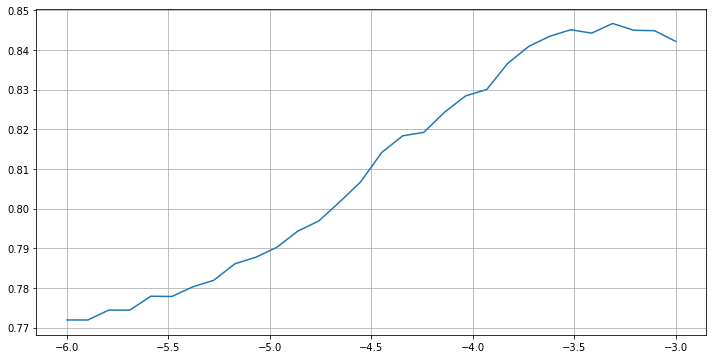

0.03650358414043513 -3.310344827586207


In [40]:
# Plot CV AUCs
print(cv_aucs)
plt.figure(figsize=(12,6))
plt.plot(np.log(regs), cv_aucs)
plt.grid(axis='both')
plt.show()

max_reg = regs[np.argmax(np.array(cv_aucs))]
print(max_reg, np.log(max_reg))

In [ ]:
# Choose best regularization parameter based on CV plot
optimal_log_reg = -3.6
optimal_reg = np.exp(optimal_log_reg)
print(optimal_log_reg, optimal_reg)

# Fit "optimal model"
optimal_sgl = LogisticGroupLasso(groups=clusters['x'], group_reg=optimal_reg*(1/6), l1_reg=optimal_reg*(5/6), n_iter=1000, 
                         tol=1e-6, old_regularisation=False, warm_start=False, random_state=seed)
optimal_sgl.fit(X_train_3, y_train_3)

# Store optimal model
optimal_sgl_3 = optimal_sgl

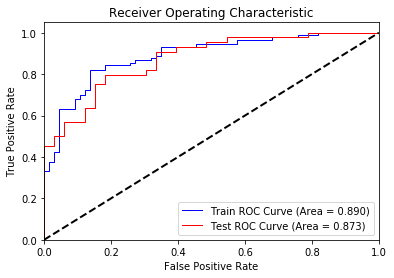

In [21]:
# Plot Train and Test ROCs
y_pred_probs_train = optimal_sgl.predict_proba(X_train_3)[1] # predicted probability y = 1
y_pred_probs_test = optimal_sgl.predict_proba(X_test_3)[1]

# Train
fpr, tpr, thresholds = roc_curve(y_train_3, y_pred_probs_train, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=1, label='Train ROC Curve (Area = %0.3f)' % roc_auc)
training_aurocs[2] = roc_auc

# Test
fpr, tpr, thresholds = roc_curve(y_test_3, y_pred_probs_test, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Test ROC Curve (Area = %0.3f)' % roc_auc)
generalization_aurocs[2] = roc_auc

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

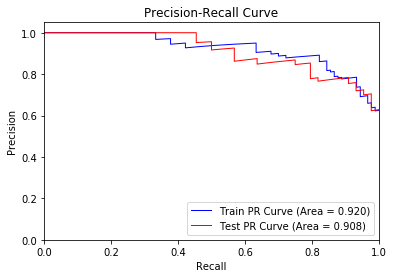

In [22]:
# Plot Train and Test PR Curves

# Train
precision, recall, thresholds = precision_recall_curve(y_train_3, y_pred_probs_train, pos_label=1)
prc_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, color='blue', lw=1, label='Train PR Curve (Area = %0.3f)' % prc_auc)
training_auprcs[2] = prc_auc

# Test
precision, recall, thresholds = precision_recall_curve(y_test_3, y_pred_probs_test, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Test PR Curve (Area = %0.3f)' % prc_auc)
generalization_auprcs[2] = prc_auc

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Save model coefficients
sparsity_mask = optimal_sgl.sparsity_mask_
print("Number of chosen variables: {0}".format(sparsity_mask.sum()))

betas_3 = optimal_sgl.coef_[:, 1] - optimal_sgl.coef_[:, 0]
betas_3[~sparsity_mask] = 0.0 # if not included in model, set to 0
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta": betas_3, 
    "Cluster": clusters['x'],
    "Included (T/F)": sparsity_mask}
)
betas_df = betas_df[betas_df['Included (T/F)'] == True][['HIF', 'Beta', 'Cluster']]
betas_df.sort_values(by="Beta", ascending=False)

Number of chosen variables: 31


,HIF,Beta,Cluster
513,REGION PROPERTIES: PERIMETER^2 / AREA OF NECROSIS_HE,0.264831,2
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.243285,20
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.115307,22
510,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF NECROSIS_HE,0.092272,2
478,REGION PROPERTIES: LACUNARITY OF NECROSIS_HE,0.078847,2
508,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF EPITHELIAL_HE,0.076661,20
35,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN TUMOR_HE,0.026430,10
155,CELL CLUSTERING PROPERTIES: WITHIN CLUSTER DISPERSION MEAN OF FIBROBLAST IN TUMOR_HE,0.024399,3
34,CELL CLUSTERING PROPERTIES: CALINSKI-HARABASZ INDEX OF FIBROBLAST IN STROMA_HE,0.023648,10
95,CELL CLUSTERING PROPERTIES: CLUSTER SIZE MEAN OF FIBROBLAST IN TUMOR_HE,0.022519,3


## Compute Ensemble Model

In [24]:
betas_df = pd.DataFrame({
    "HIF": clusters['Unnamed: 0'],
    "Beta_1": betas_1, 
    "Beta_2": betas_2,
    "Beta_3": betas_3,
    "Cluster": clusters['x']
    }
)
betas_df['Beta'] = (betas_df['Beta_1'] + betas_df['Beta_2'] + betas_df['Beta_3'])/3.0
betas_df.sort_values(by="Beta", ascending=False)

,HIF,Beta_1,Beta_2,Beta_3,Cluster,Beta
513,REGION PROPERTIES: PERIMETER^2 / AREA OF NECROSIS_HE,0.372650,0.310319,0.264831,2,0.315933
509,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF ESI_0080_HE,0.488490,0.112195,0.243285,20,0.281324
435,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF TUMOR_HE,0.117761,0.105432,0.020491,19,0.081228
508,REGION PROPERTIES: PERIMETER^2 / AREA OF LARGEST REGION OF EPITHELIAL_HE,0.124123,0.010283,0.076661,20,0.070356
475,REGION PROPERTIES: LACUNARITY OF LARGEST REGION OF NECROSIS_HE,0.000000,0.072838,0.115307,22,0.062715
...,...,...,...,...,...,...
488,REGION PROPERTIES: MINOR AXIS LENGTH (MM) OF LARGEST REGION OF NECROSIS_HE,-0.195962,0.000000,0.000000,2,-0.065321
431,REGION PROPERTIES: AVERAGE SOLIDITY OF SIGNIFICANT REGIONS OF EPITHELIAL_HE,-0.124622,-0.091922,-0.010275,19,-0.075606
429,REGION PROPERTIES: AVERAGE EXTENT OF SIGNIFICANT REGIONS OF STROMA_HE,-0.117759,-0.105432,-0.020491,19,-0.081227
464,REGION PROPERTIES: FRACTAL DIMENSION OF LARGEST REGION OF ESI_0080_HE,-0.166806,-0.149983,-0.148941,20,-0.155244


## Compute Final Train / Test Metrics

In [25]:
print(training_aurocs)
print(np.mean(training_aurocs), np.std(training_aurocs))

[0.954375212802179, 0.8844058563159687, 0.8900673400673399]
0.9096161363951625 0.03173372853577733


In [26]:
print(generalization_aurocs)
print(np.mean(generalization_aurocs), np.std(generalization_aurocs))

[0.7824915824915825, 0.9063973063973064, 0.8732782369146006]
0.8540557086011632 0.05237866168724978


In [27]:
print(training_auprcs)
print(np.mean(training_auprcs), np.std(training_auprcs))

[0.9652415771053512, 0.9114151555063228, 0.9199526564868221]
0.9322031296994987 0.023620280636068764


In [28]:
print(generalization_auprcs)
print(np.mean(generalization_auprcs), np.std(generalization_auprcs))

[0.8565570687613787, 0.9207886577477263, 0.908242626475666]
0.8951961176615905 0.027797875219814777


## Evaluate Hold-Out Set

In [29]:
holdout_df = pd.read_csv("{0}/data/genetic_data/TIGIT/datasets/skcm.tigit.joined.HOLDOUT.csv".format(working_dir))
holdout_df = holdout_df.iloc[:,1:]
holdout_df

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE,joined.TIGIT_label
0,163.921200,45.223812,13.615744,22.420416,186.341616,7696.558403,5268.945495,5005.032707,7724.181471,5284.515501,...,65.396020,0.622250,2.410235,5.753684,1.239659,28.086666,70.449612,120.738170,39.234392,0
1,141.532560,100.245380,32.880544,87.347344,228.879904,6868.945904,6235.573192,5409.246822,6848.228451,6292.285983,...,114.697706,0.148376,0.668360,1.053266,0.493709,47.155227,126.110550,236.526940,119.425076,0
2,121.176480,51.477924,3.276256,27.246000,148.422480,7388.808139,5836.898461,4952.369895,7437.729140,6368.567942,...,325.065314,0.462136,0.854735,2.936211,0.916303,87.508731,139.244154,253.248183,117.933618,0
3,167.558544,73.330872,23.951872,25.908240,193.466784,7722.948432,6140.365860,5299.714557,7778.938759,4821.594766,...,324.221030,3.622614,6.736590,22.734080,6.181940,49.105225,124.722368,309.901406,84.029928,0
4,101.452048,120.132940,0.992816,71.304064,172.756112,6990.605716,7120.778645,6677.939444,7320.300128,5684.393698,...,2453.852400,9.906158,26.795315,52.269110,27.391216,607.952242,1191.305232,1979.494465,1174.048186,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,33.106596,24.048208,0.038168,8.643060,41.749656,7547.275858,6714.751648,5671.243242,7544.633626,6436.178972,...,387.548103,0.060411,0.540581,1.272697,0.311380,27.577586,87.199845,198.309395,62.922674,0
79,13.164656,21.161784,90.599176,117.923880,131.088536,4797.422966,5308.291727,6091.079631,6212.650674,2906.518264,...,200.757448,7.444175,16.964543,16.748092,15.813740,20.889266,21.784553,49.481072,46.609720,1
80,33.419444,17.256700,2.542452,8.763660,42.183104,6843.317393,6259.368527,5521.951829,6548.059000,5640.727395,...,907.164157,2.603275,5.794851,32.178336,8.747578,65.590559,179.756269,456.886735,146.883454,1
81,100.681360,57.929560,6.622132,20.367232,121.048592,7434.365367,6478.238887,5580.742329,7276.272436,4979.431213,...,510.604865,0.506549,2.295892,12.765603,2.569216,50.595264,139.324379,470.363376,121.224045,1


In [30]:
# Normalize HIFs and define X, y
X_holdout = holdout_df.iloc[:,:607]
X_normalized_holdout = (X_holdout-X_holdout.mean())/X_holdout.std()
X_normalized_holdout

,AREA..MM2..OF..EPITHELIAL..IN..TISSUE._FFPE,AREA..MM2..OF..ESI_0080..IN..TISSUE._FFPE,AREA..MM2..OF..NECROSIS..IN..TISSUE._FFPE,AREA..MM2..OF..STROMA..IN..TISSUE._FFPE,AREA..MM2..OF..TUMOR..IN..TISSUE._FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.EPITHELIAL_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.ESI_0080_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.STROMA_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.CANCER.IN.TUMOR_FFPE,CELL.CLUSTERING.PROPERTIES..BALL.HALL.INDEX.OF.FIBROBLAST.IN.EPITHELIAL_FFPE,...,DENSITY..LYMPHOCYTE.CELLS..IN..STROMA._FFPE,DENSITY..LYMPHOCYTE.CELLS..IN..TUMOR._FFPE,DENSITY..MACROPHAGE.CELLS..IN..EPITHELIAL._FFPE,DENSITY..MACROPHAGE.CELLS..IN..ESI_0080._FFPE,DENSITY..MACROPHAGE.CELLS..IN..STROMA._FFPE,DENSITY..MACROPHAGE.CELLS..IN..TUMOR._FFPE,DENSITY..PLASMA.CELLS..IN..EPITHELIAL._FFPE,DENSITY..PLASMA.CELLS..IN..ESI_0080._FFPE,DENSITY..PLASMA.CELLS..IN..STROMA._FFPE,DENSITY..PLASMA.CELLS..IN..TUMOR._FFPE
0,1.044562,-0.508236,0.121522,-0.647845,0.545099,1.022190,-1.591870,-1.351013,1.115279,-0.237297,...,-1.099987,-0.952764,-0.352600,-0.613934,-0.721710,-0.615166,-0.679874,-0.842525,-0.950074,-0.859693
1,0.660949,0.773096,1.252438,1.259912,1.140950,0.006503,-0.017814,-0.679322,-0.194413,0.851863,...,-1.204274,-0.895137,-0.370781,-0.682884,-0.842777,-0.644396,-0.578543,-0.690279,-0.735308,-0.604036
2,0.312162,-0.362591,-0.485444,-0.506054,0.013950,0.644504,-0.667016,-1.438523,0.686986,0.934306,...,-1.038063,-0.649245,-0.358743,-0.675506,-0.794278,-0.627837,-0.364102,-0.654356,-0.704293,-0.608790
3,1.106886,0.146316,0.728291,-0.545362,0.644904,1.054578,-0.172849,-0.861334,1.197150,-0.737605,...,-0.804386,-0.650232,-0.237488,-0.442680,-0.284351,-0.421505,-0.568180,-0.694076,-0.599212,-0.716879
4,-0.025803,1.236234,-0.619490,0.788510,0.354801,0.155810,1.423654,1.428888,0.511411,0.194876,...,1.335909,1.839026,0.003588,0.351319,0.476374,0.409570,2.401560,2.223278,2.497575,2.758224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,-1.196854,-1.001370,-0.675532,-1.052667,-1.480259,0.838983,0.762480,-0.243958,0.846826,1.007378,...,-0.333188,-0.576211,-0.374156,-0.687942,-0.837125,-0.651540,-0.682579,-0.796709,-0.806194,-0.784172
79,-1.538545,-1.068588,4.640735,2.158347,-0.228853,-2.535775,-1.527799,0.453692,-1.144704,-2.807348,...,-1.196367,-0.794544,-0.090869,-0.037820,-0.438530,-0.044088,-0.718121,-0.975636,-1.082243,-0.836179
80,-1.191493,-1.159529,-0.528521,-1.049124,-1.474188,-0.024950,0.020935,-0.492039,-0.643214,0.147683,...,1.055901,0.031152,-0.276596,-0.479958,-0.041098,-0.320972,-0.480576,-0.543546,-0.326581,-0.516495
81,-0.039008,-0.212347,-0.289029,-0.708174,-0.369487,0.700414,0.377343,-0.394345,0.445583,-0.567021,...,-0.101258,-0.432374,-0.357039,-0.618460,-0.541106,-0.563068,-0.560262,-0.654136,-0.301584,-0.598300


In [31]:
y_holdout = holdout_df.iloc[:,607]
print(np.sum(y_holdout))

53


In [32]:
X_normalized_holdout = np.array(X_normalized_holdout)
y_pred_probs_1 = optimal_sgl_1.predict_proba(X_normalized_holdout)[1] # predicted probability y = 1
y_pred_probs_2 = optimal_sgl_2.predict_proba(X_normalized_holdout)[1]
y_pred_probs_3 = optimal_sgl_3.predict_proba(X_normalized_holdout)[1] 

In [33]:
# Ensemble (average) predictions
y_pred_probs_ensemble = np.mean(np.array([list(y_pred_probs_1), list(y_pred_probs_2), list(y_pred_probs_3)]), axis=0)
# y_pred_probs_ensemble

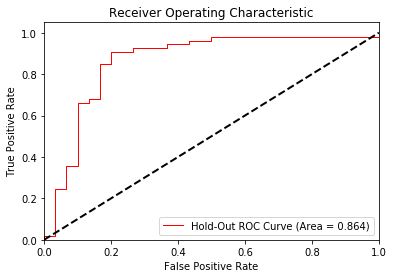

In [34]:
# Hold Out ROC
fpr, tpr, thresholds = roc_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='red', lw=1, label='Hold-Out ROC Curve (Area = %0.3f)' % roc_auc)

# Plot parameters
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

Original ROC area: 0.864


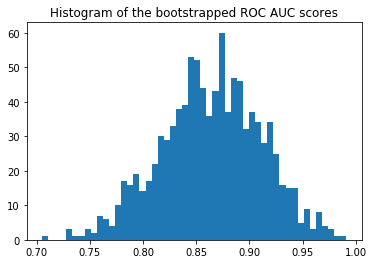

Confidence interval for the score: [0.771 - 0.954]


In [35]:
# Generate ROC 95% CI

print("Original ROC area: {:0.3f}".format(roc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = roc_auc_score(y_holdout[indices], y_pred_probs_ensemble[indices])
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC AUC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))

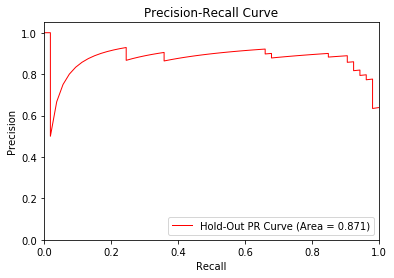

In [36]:
# Hold Out PR Curve
precision, recall, thresholds = precision_recall_curve(y_holdout, y_pred_probs_ensemble, pos_label=1)
prc_auc = auc(recall, precision)
plt.plot(recall, precision, color='red', lw=1, label='Hold-Out PR Curve (Area = %0.3f)' % prc_auc)

# Plot parameters
# plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

Original PRC area: 0.871


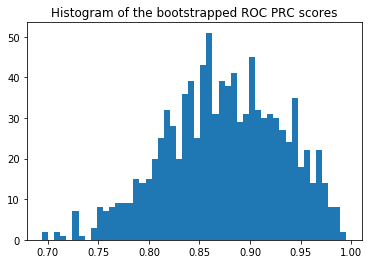

Confidence interval for the score: [0.757 - 0.976]


In [37]:
# Generate PRC 95% CI
print("Original PRC area: {:0.3f}".format(prc_auc))

n_bootstraps = 1000
bootstrapped_scores = []

rng = np.random.RandomState(seed)
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(y_pred_probs_ensemble), len(y_pred_probs_ensemble))
    
    if len(np.unique(y_holdout[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    
    precision, recall, thresholds = precision_recall_curve(y_holdout[indices], y_pred_probs_ensemble[indices], pos_label=1)
    score = auc(recall, precision)
    bootstrapped_scores.append(score)
    # print("Bootstrap #{} ROC area: {:0.3f}".format(i + 1, score))

plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of the bootstrapped ROC PRC scores')
plt.show()

sorted_scores = np.array(bootstrapped_scores)
sorted_scores.sort()

# Computing the lower and upper bound of the 94% confidence interval
confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
print("Confidence interval for the score: [{:0.3f} - {:0.3}]".format(
    confidence_lower, confidence_upper))